# Project: Predicting Speedrun World Record Times
This project aims to predict the world record times for speedruns based on features extracted from two datasets: game data and category data.
It utilizes supervised machine learning techniques with a focus on regression models to accomplish this task.
Algorithms used include Linear Regression, Ridge Regression, Lasso Regression, Random Forest, and Gradient Boosting.

The goal is to identify patterns in the data and create a robust model for predicting times.
## Google Colab: https://colab.research.google.com/drive/1AzXACizd_GWLmmZ_O2BIF8-PG_H65f7-?usp=sharing

## GitHub Repo: https://github.com/kmora2b/speedrun_ml_project

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import normaltest, skew
from sklearn.model_selection import GridSearchCV

IS_GCOLAB = False #CHANGE TO FALSE IF LOCAL

if IS_GCOLAB:
  # Mount Google Drive to access files
  from google.colab import drive
  drive.mount('/content/drive')

## Load and Explore the Dataset

The dataset contains speedrunning records for various games, including features such as game name, category, platform, and the world record time.
The goal is to predict the world record time for a given game and category based on these features.


---



##Data Source
The dataset is publicly available on Kaggle and was created by Matheus Turatti.

###Citation: Turatti, M. (n.d.). Game Speedrun Records [Data set]. Kaggle. https://www.kaggle.com/datasets/matheusturatti/game-speedrun-records



---



## Dataset Description
The dataset contains 2 datasets called Game Data and Category Data and we will combine them based on Game_Id to make a combined dataset

### Game Data Description:
This dataset contains information about games, including:
  - Game_Id: Unique identifier for each game.
  - Abbreviation, Name: Game details like name and abbreviation.
  - Genres, Platforms: Categories describing the game's genre and platform.
  - Total_Runs: Total speedrun attempts for the game.
  - Release_Date: The release date of the game.
  - The dataset has 1001 rows and 7 columns.
  - Data types include numeric and categorical features.

### Category Data Description:
This dataset contains information about game categories and records, including:
  - Game_Id: Unique identifier for games (key for merging).
  - Category, Subcategory: Game categories.
  - Time_0: Speedrun record time.
  - Num_Runs: Number of runs for this category.
  - Players_0, Record_Date_0: Player information and record dates.
  - The dataset has 47691 rows and 19 columns.
  - Data types include numeric and categorical features.

### Combined Dataset Description:
 - The combined dataset integrates the game details from 'game_data' and category-level data from 'category_data'.
 - The reason for merging is to align speedrun record times and player data (from category data) with game metadata (from game data),
   enabling a comprehensive analysis and prediction model.
 - Combined Dataset Size: 47779 rows, 25 columns.
 - Key features include:
   - Game_Id: Serves as the unique key for merging.
   - Abbreviation, Name, Genres, Platforms, Release_Date: Game metadata.
   - Time_0, Num_Runs, Players_0, Record_Date_0: Speedrun records and player information.

In [2]:
# Print available files in the directory
print("Files in dataset directory:")
if IS_GCOLAB:
  base_path = '/content/drive/My Drive/Colab Notebooks/dataset'
else:
  base_path = '.' #replace if local
for file_name in os.listdir(base_path):
    print(file_name)

# Load and combine the datasets
category_data_path = os.path.join(base_path, 'category_data_.csv')
game_data_path = os.path.join(base_path, 'game_data_.csv')

# Load the downloaded dataset
category_data = pd.read_csv(category_data_path)
game_data = pd.read_csv(game_data_path)

# Merge the two datasets on the common column, assuming 'game_id' is the key
combined_data = pd.merge(game_data, category_data, on='Game_Id', how='inner')

# Display basic information about the combined dataset
print("Dataset Overview:")
print(combined_data.info())
print(combined_data.head())

# Data Description
print("Category Data Columns:")
print(category_data.columns)

print("\nGame Data Columns:")
print(game_data.columns)

print("\nData Columns:")
print(combined_data.columns)

# Display dataset sizes and basic statistics
print("\nGame Data Description:")
print(game_data.describe(include='all'))
print("\nCategory Data Description:")
print(category_data.describe(include='all'))
print("\nData Description:")
print(combined_data.describe(include='all'))

# Display dataset sizes
print(f"Game Data Size: {game_data.shape[0]} rows, {game_data.shape[1]} columns")
print(f"Category Data Size: {category_data.shape[0]} rows, {category_data.shape[1]} columns")
print(f"Data Size: {combined_data.shape[0]} rows, {combined_data.shape[1]} columns")



Files in dataset directory:
category_data_.csv
.ipynb_checkpoints
LICENSE
game_data_.csv
speedrun_analysis.ipynb
.git
README.md
Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47779 entries, 0 to 47778
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Game_Id         47779 non-null  int64  
 1   Abbreviation    47691 non-null  object 
 2   Name            47691 non-null  object 
 3   Genres          47691 non-null  object 
 4   Platforms       47441 non-null  object 
 5   Total_Runs      47691 non-null  float64
 6   Release_Date    47779 non-null  object 
 7   Category_Id     47779 non-null  int64  
 8   Subcategory_Id  47779 non-null  int64  
 9   Misc            47779 non-null  bool   
 10  Category        47779 non-null  object 
 11  Num_Runs        47779 non-null  int64  
 12  Subcategory     45125 non-null  object 
 13  Time_0          25397 non-null  float64
 14  Country_0       2539

## Data Cleaning

Missing values are dropped to ensure a clean dataset for training the models. The categorical features are one-hot encoded for compatibility with machine learning algorithms.

In [3]:
# Data Cleaning
print("\nData Cleaning:")
print("Initial shape of dataset:", combined_data.shape)

# Check for missing values
missing_values = combined_data.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

# Drop rows with missing values
cleaned_data = combined_data.dropna()
print("Shape after dropping missing values:", cleaned_data.shape)



Data Cleaning:
Initial shape of dataset: (47779, 25)
Missing Values in Each Column:
Game_Id               0
Abbreviation         88
Name                 88
Genres               88
Platforms           338
Total_Runs           88
Release_Date          0
Category_Id           0
Subcategory_Id        0
Misc                  0
Category              0
Num_Runs              0
Subcategory        2654
Time_0            22382
Country_0         22382
Players_0         22382
Record_Date_0     22407
Time_1            27648
Country_1         27648
Players_1         27648
Record_Date_1     27701
Time_2            31251
Country_2         31251
Players_2         31251
Record_Date_2     31326
dtype: int64
Shape after dropping missing values: (14057, 25)


### Visualize Data Cleaning

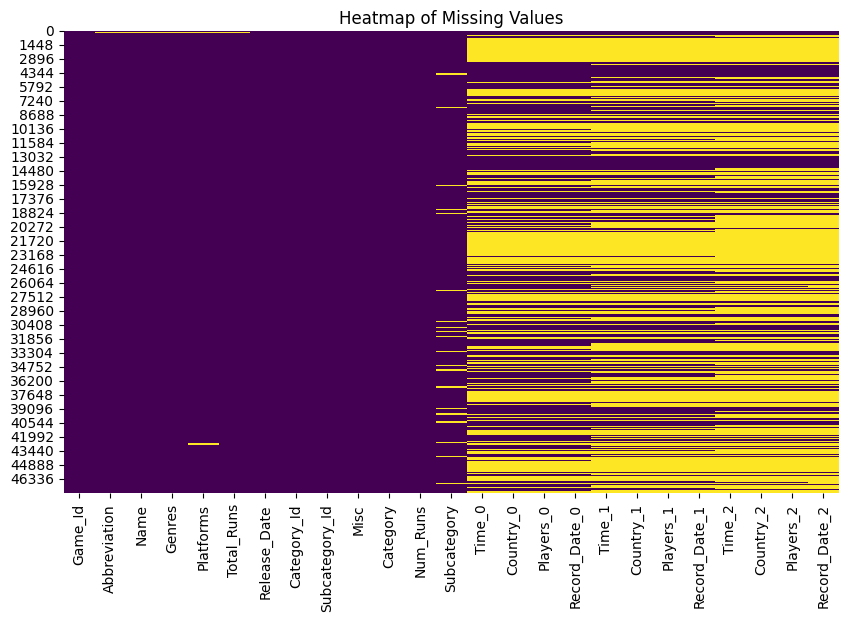

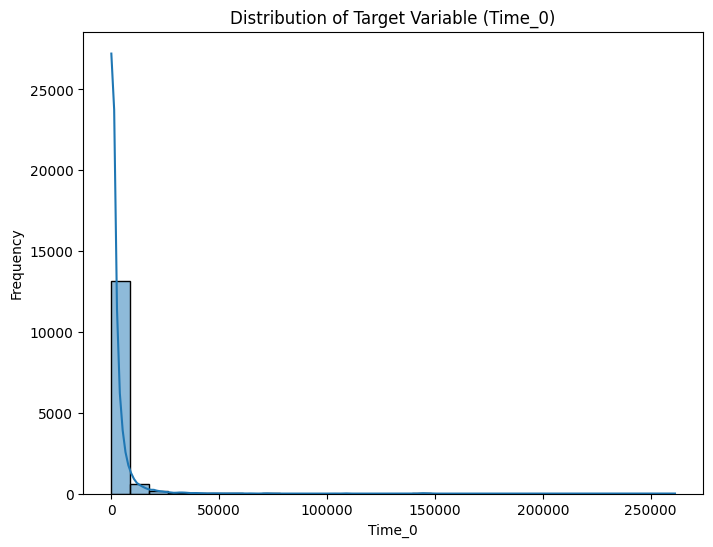

Skewness of Game_Id: 0.67
Skewness of Total_Runs: 3.15
Skewness of Category_Id: 8.63
Skewness of Subcategory_Id: 22.80
Skewness of Num_Runs: 24.07
Skewness of Time_0: 12.40
Skewness of Time_1: 13.22
Skewness of Time_2: 12.25


In [4]:
# Visualize missing data (if any)
plt.figure(figsize=(10, 6))
# Visualizing missing data helps identify columns with incomplete entries, allowing us to decide on appropriate cleaning strategies.
# The heatmap below shows where missing values are located in the dataset.
sns.heatmap(combined_data.isnull(), cbar=False, cmap="viridis")
# Observations:
# - The heatmap reveals specific columns with missing values.
# - These gaps indicate areas requiring attention during the cleaning process, such as dropping or imputing missing values.
plt.title("Heatmap of Missing Values")
plt.show()

# Check for data imbalance in the target variable
plt.figure(figsize=(8, 6))
# Checking for data imbalance is crucial for regression tasks to ensure that the target variable has a reasonable distribution.
# The histogram below visualizes the distribution of the target variable (Time_0).
sns.histplot(cleaned_data['Time_0'], kde=True, bins=30)
# Observations:
# - The histogram indicates the distribution of speedrun times (Time_0).
# - Any extreme skewness or outliers could suggest the need for transformations or additional handling.
plt.title("Distribution of Target Variable (Time_0)")
plt.xlabel("Time_0")
plt.ylabel("Frequency")
plt.show()

# Detect skewness in numerical features
numerical_features = cleaned_data.select_dtypes(include=[np.number]).columns
for feature in numerical_features:
    # Detecting skewness helps identify numerical features that deviate significantly from a normal distribution.
    # Observations:
    # - Skewness values near 0 suggest normal distribution, while high positive/negative values indicate skewness.
    # - Skewed features may require log or other transformations to stabilize variance and improve model performance.
    # High skewness values may indicate the need for transformations to improve model performance.
    skewness = skew(cleaned_data[feature].dropna())
    print(f"Skewness of {feature}: {skewness:.2f}")

## EDA

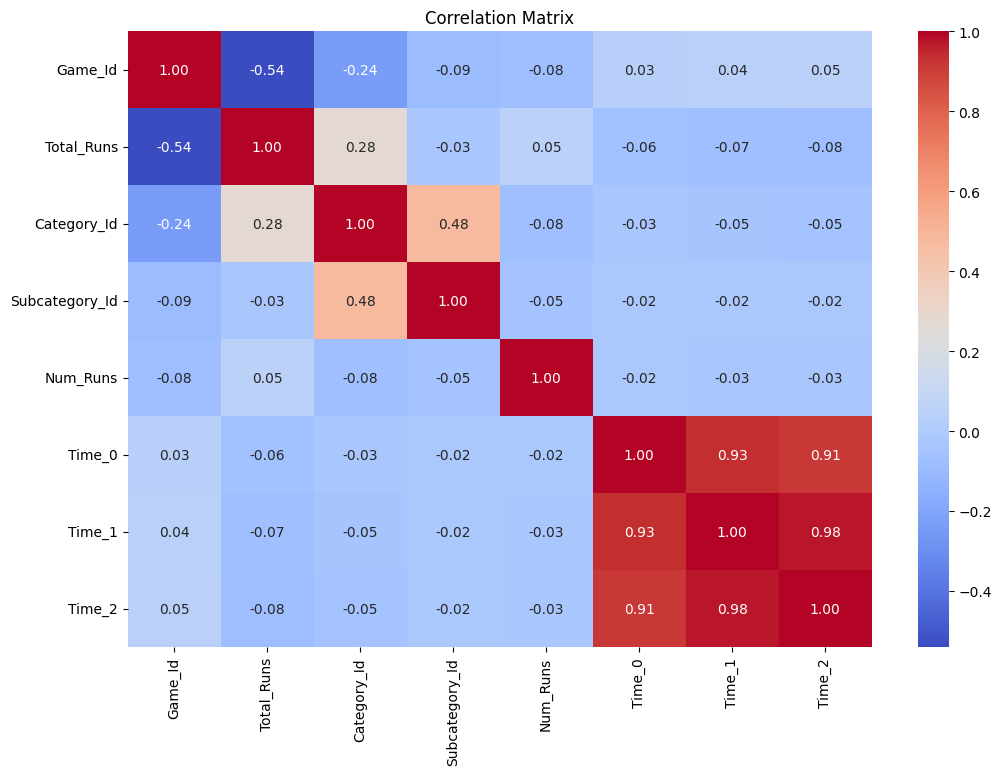

Normality test for Time_0: Statistic=56918.65, p-value=0.000
The target variable 'Time_0' does not follow a normal distribution (p < 0.05). Consider transformations.


In [5]:
# Display basic information about the combined dataset
# Extra EDA: Analyze correlations between features and the target variable.

# Filter numeric columns for the correlation matrix
numeric_data = combined_data.select_dtypes(include=[np.number])

# Compute and visualize the correlation matrix
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Observations:
# - The correlation matrix helps identify relationships between features and the target variable (Time_0).
# - Features with high correlations (positive or negative) may have stronger predictive power for the target.
# - Multicollinearity can also be detected, prompting consideration for feature selection or dimensionality reduction.

# Perform a statistical test for normality on the target variable
stat, p = normaltest(combined_data['Time_0'].dropna())
print(f"Normality test for Time_0: Statistic={stat:.2f}, p-value={p:.3f}")
if p < 0.05:
    print("The target variable 'Time_0' does not follow a normal distribution (p < 0.05). Consider transformations.")
else:
    print("The target variable 'Time_0' follows a normal distribution (p >= 0.05). No transformation needed.")

## Feature Engineering

In [6]:
# Feature Engineering
# Assuming 'Time_0' is the target variable
categorical_features = [col for col in cleaned_data.columns if cleaned_data[col].dtype == 'object' and col != 'Time_0']
data_encoded = pd.get_dummies(cleaned_data, columns=categorical_features, drop_first=True)
# Observations:
# - One-hot encoding converts categorical variables into numerical format for model compatibility.
# - Dropping the first category prevents multicollinearity while retaining the information needed for predictions.


## Split Data for Training and Testing

The dataset is split into training and testing sets (80%-20%) to evaluate the model's performance on unseen data.

In [7]:
# Define features (X) and target (y)
X = data_encoded.drop('Time_0', axis=1)
y = data_encoded['Time_0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train Multiple Models

Linear Regression, Ridge Regression, Lasso Regression, Random Forest, and Gradient Boosting models are trained and their performance is compared using RMSE and R-squared metrics.

## WARNING: SUPER SLOW

In [8]:

models = {
    'Linear Regression': LinearRegression(),
    #'Ridge Regression': Ridge(),
    #'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}
X_train_sample = X_train.sample(frac=0.1, random_state=42) #modify frac to get a percentage of the data
y_train_sample = y_train.loc[X_train_sample.index]

# Efficient training loop with progress display
from tqdm import tqdm
for name, model in tqdm(models.items(), desc='Training Models'):
    model.fit(X_train_sample, y_train_sample)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    results[name] = {'RMSE': rmse, 'R^2': r2}

Training Models: 100%|████████████████████████████| 3/3 [01:59<00:00, 39.88s/it]


## Hyperparameter Tuning and Cross-Validation

Random Forest is tuned using grid search for optimal parameters. Gradient Boosting is evaluated using cross-validation.
WARNING: SUPER SLOW

In [9]:
# Reduced parameter grid for Random Forest
param_grid = {
    'n_estimators': [100],  # Reduced to one value
    'max_depth': [None, 10],  # Simplified depth levels
    'min_samples_split': [2, 5]  # Fewer options
}

# Grid search with optimizations
rf_grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,  # Reduce cross-validation folds
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Use all available processors
)

# Sampled data for faster tuning
X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Fit on sampled data
rf_grid_search.fit(X_train_sample, y_train_sample)
best_rf_model = rf_grid_search.best_estimator_

# Predictions and evaluation
rf_predictions = best_rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest - Tuned: RMSE = {rf_rmse:.2f}, R^2 = {rf_r2:.2f}")

# Gradient Boosting Cross-Validation
gbr_model = GradientBoostingRegressor(random_state=42)
cross_val_scores = cross_val_score(
    gbr_model,
    X_train_sample,
    y_train_sample,
    cv=3,  # Use sampled data and fewer folds
    scoring='neg_mean_squared_error'
)
mean_cv_rmse = np.sqrt(-cross_val_scores.mean())
print(f"Gradient Boosting CV Mean RMSE: {mean_cv_rmse:.2f}")


Random Forest - Tuned: RMSE = 2352.61, R^2 = 0.84
Gradient Boosting CV Mean RMSE: 1219.76


## Results and Performance Comparison

The RMSE and R-squared metrics for each model are compared. The performance of the tuned Random Forest model and Gradient Boosting is highlighted.

In [14]:

print("Model Results:")
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['RMSE']:.2f}, R^2 = {metrics['R^2']:.2f}")

print("Best Random Forest Model After Tuning:")
print(f"RMSE: {rf_rmse:.2f}, R^2: {rf_r2:.2f}")

print("Gradient Boosting Cross-Validation Mean RMSE:")
print(f"Mean CV RMSE: {mean_cv_rmse:.2f}")


Model Results:
Linear Regression: RMSE = 1205.37, R^2 = 0.96
Random Forest: RMSE = 2357.26, R^2 = 0.84
Gradient Boosting: RMSE = 2117.27, R^2 = 0.87
Best Random Forest Model After Tuning:
RMSE: 2352.61, R^2: 0.84
Gradient Boosting Cross-Validation Mean RMSE:
Mean CV RMSE: 1219.76


## Visualize Model Performance

A bar plot compares the RMSE values across different models.

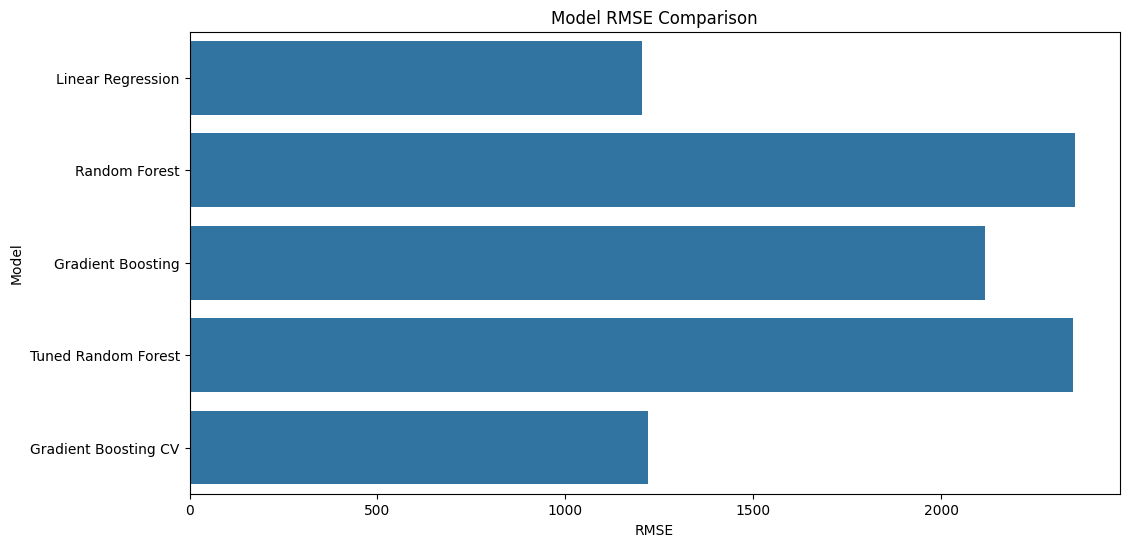

In [15]:

plt.figure(figsize=(12, 6))
model_names = list(results.keys()) + ["Tuned Random Forest", "Gradient Boosting CV"]
rmse_values = [metrics['RMSE'] for metrics in results.values()] + [rf_rmse, mean_cv_rmse]

sns.barplot(x=rmse_values, y=model_names, orient='h')
plt.title("Model RMSE Comparison")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.show()


## Feature Importance from Best Random Forest Model

The top 10 most important features are visualized for the best Random Forest model.

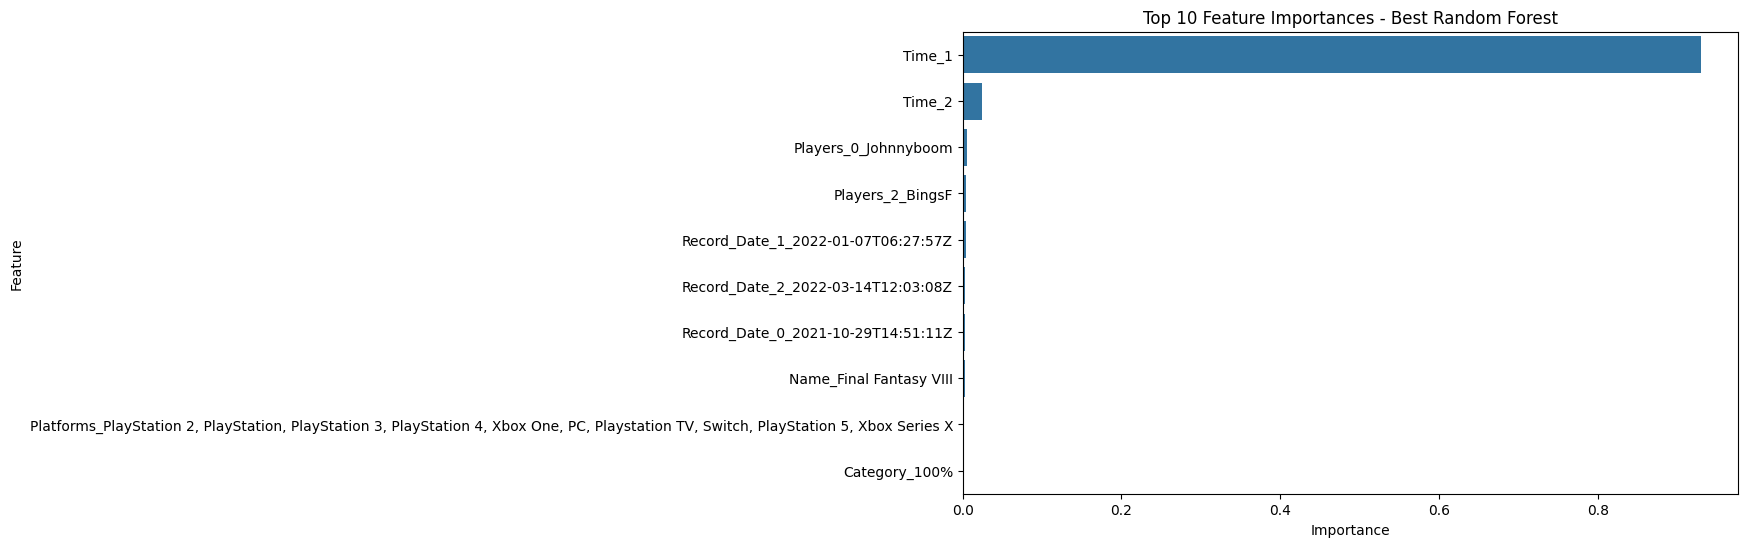

In [16]:

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title("Top 10 Feature Importances - Best Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Discussion and Suggestions for Improvement

1. **Learning and Takeaways:**
   - Random Forest achieved the best performance.
   - Gradient Boosting also performed well with cross-validation.
2. **Challenges:**
   - Linear Regression struggled due to potential multicollinearity.
   - Lasso Regression may have overly penalized features.
3. **Suggestions for Improvement:**
   - Experiment with stacking ensemble techniques.
   - Perform feature selection or dimensionality reduction (e.g., PCA).
   - Include additional features such as player statistics or game metadata.